In [3]:
import ccxt
import itertools
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import ta
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
#import ace_tools as tools
%matplotlib inline

In [4]:
def fetch_bybit_data(symbol='BTC/USDT', timeframe='5m', limit=1000):
    exchange = ccxt.bybit({
        'options': {'defaultType': 'linear'}  # Required for USDT Perpetuals
    })
    exchange.load_markets()
    
    data = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit, params = {"paginate": True})
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

In [5]:
df = fetch_bybit_data(timeframe='5m', limit=10000)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9990 entries, 2025-03-30 23:20:00 to 2025-05-04 16:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    9990 non-null   float64
 1   high    9990 non-null   float64
 2   low     9990 non-null   float64
 3   close   9990 non-null   float64
 4   volume  9990 non-null   float64
dtypes: float64(5)
memory usage: 468.3 KB


In [7]:
df.head()

,open,high,low,close,volume
timestamp,,,,,
2025-03-30 23:20:00,82236.2,82260.5,81983.0,82011.0,19.026954
2025-03-30 23:25:00,82011.0,82192.0,81926.2,81961.3,24.826694
2025-03-30 23:30:00,81961.3,82095.9,81933.6,82038.6,25.623224
2025-03-30 23:35:00,82038.6,82211.6,81980.6,82199.7,15.563680
2025-03-30 23:40:00,82199.7,82354.1,82189.3,82318.6,9.374781


In [8]:
fig = go.Figure()

# === Price Line ===
fig.add_trace(go.Scatter(
    x=df.index, y=df['close'],
    mode='lines', name='Price', line=dict(color='black')
))

fig.show()

In [9]:


# ========== Momentum Features ==========
df['return_1'] = df['close'].pct_change(1).shift(1)  # shifted to avoid leakage
df['return_3'] = df['close'].pct_change(3).shift(1)
df['return_5'] = df['close'].pct_change(5).shift(1)
df['return_10'] = df['close'].pct_change(10).shift(1)

df['roc_10'] = ta.momentum.ROCIndicator(close=df['close'], window=10).roc().shift(1)
df['rsi_14'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi().shift(1)
df['macd_diff'] = ta.trend.MACD(close=df['close']).macd_diff().shift(1)

# ========== Volatility Features ==========
df['volatility_5'] = df['return_1'].rolling(window=5).std().shift(1)
df['volatility_10'] = df['return_1'].rolling(window=10).std().shift(1)
df['volatility_20'] = df['return_1'].rolling(window=20).std().shift(1)

df['atr_14'] = ta.volatility.AverageTrueRange(
    high=df['high'], low=df['low'], close=df['close'], window=14
).average_true_range().shift(1)

bb = ta.volatility.BollingerBands(close=df['close'], window=20)
df['bb_width'] = bb.bollinger_wband().shift(1)

df['volume_change'] = df['volume'].pct_change(1).shift(1)

# ========== Trend Features (EMA) ==========
df['ema_5'] = ta.trend.EMAIndicator(close=df['close'], window=5).ema_indicator().shift(1)
df['ema_10'] = ta.trend.EMAIndicator(close=df['close'], window=10).ema_indicator().shift(1)
df['ema_20'] = ta.trend.EMAIndicator(close=df['close'], window=20).ema_indicator().shift(1)

df['ema_slope_5'] = df['ema_5'].diff().shift(1)
df['ema_slope_10'] = df['ema_10'].diff().shift(1)
df['ema_slope_20'] = df['ema_20'].diff().shift(1)

df['price_vs_ema20'] = ((df['close'] - df['ema_20']) / df['ema_20']).shift(1)

# ========== Candle Pattern Features ==========
df['candle_body'] = (df['close'] - df['open']).abs().shift(1)
df['upper_wick'] = (df['high'] - df[['close', 'open']].max(axis=1)).shift(1)
df['lower_wick'] = (df[['close', 'open']].min(axis=1) - df['low']).shift(1)
df['body_to_range'] = (df['candle_body'] / (df['high'] - df['low'] + 1e-6)).shift(1)

# ========== Temporal Features ==========
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
df['day_of_week'] = df.index.dayofweek

In [10]:
# Parameters
forward_window = 6  # e.g., 6 candles = 30 minutes for 5-min data
threshold = 0.002  # 0.2% return threshold

# Forward return (shifted to not leak future info)
df['future_return'] = (df['close'].shift(-forward_window) - df['close']) / df['close']

# Label based on return threshold
conditions = [
    df['future_return'] > threshold,     # significant upward move
    df['future_return'] < -threshold     # significant downward move
]
choices = [1, -1]  # 1 = uptrend (go long), -1 = downtrend (go short)

df['label'] = np.select(conditions, choices, default=0)

In [11]:
# Create Plotly interactive plot
fig = go.Figure()

# Close Price Line
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['close'],
    mode='lines',
    name='Close Price',
    line=dict(color='black')
))

# Long Signals
fig.add_trace(go.Scatter(
    x=df.index[df['label'] == 1],
    y=df['close'][df['label'] == 1],
    mode='markers',
    name='Long Signal',
    marker=dict(color='green', symbol='triangle-up', size=10)
))

# Short Signals
fig.add_trace(go.Scatter(
    x=df.index[df['label'] == -1],
    y=df['close'][df['label'] == -1],
    mode='markers',
    name='Short Signal',
    marker=dict(color='red', symbol='triangle-down', size=10)
))

# Layout
fig.update_layout(
    title='BTCUSDT Close Price with Long/Short Signals (Interactive)',
    xaxis_title='Time',
    yaxis_title='Price',
    legend=dict(x=0, y=1),
    height=600
)

fig.show()

In [12]:
# Drop any NaNs
df.dropna(inplace=True)

# 🔁 Map labels to 0, 1, 2 for XGBoost
label_map = {-1: 0, 0: 1, 1: 2}
df['label_encoded'] = df['label'].map(label_map)

In [13]:
df['label_encoded'].value_counts()

label_encoded
1    6020
2    2050
0    1880
Name: count, dtype: int64

In [14]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'return_1', 'return_3',
       'return_5', 'return_10', 'roc_10', 'rsi_14', 'macd_diff',
       'volatility_5', 'volatility_10', 'volatility_20', 'atr_14', 'bb_width',
       'volume_change', 'ema_5', 'ema_10', 'ema_20', 'ema_slope_5',
       'ema_slope_10', 'ema_slope_20', 'price_vs_ema20', 'candle_body',
       'upper_wick', 'lower_wick', 'body_to_range', 'hour_sin', 'hour_cos',
       'day_of_week', 'future_return', 'label', 'label_encoded'],
      dtype='object')

In [15]:
# Define features and labels
X = df[['return_1', 'return_3',
       'return_5', 'return_10', 'roc_10', 'rsi_14', 'macd_diff',
       'volatility_5', 'volatility_10', 'volatility_20', 'atr_14', 'bb_width',
       'volume_change', 'ema_5', 'ema_10', 'ema_20', 'ema_slope_5',
       'ema_slope_10', 'ema_slope_20', 'price_vs_ema20', 'candle_body',
       'upper_wick', 'lower_wick', 'body_to_range', 'hour_sin', 'hour_cos',
       'day_of_week']]
y = df['label_encoded']

In [16]:
# Time-based train/test split (no shuffling)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [17]:
weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [18]:

# ✅ Train the model
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss'
)
model.fit(X_train, y_train, sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

In [19]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [20]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], shape=(1990,))

In [21]:
print(classification_report(y_test, y_pred, target_names=['Downtrend', 'Neutral', 'Uptrend']))

              precision    recall  f1-score   support

   Downtrend       0.23      0.38      0.29       267
     Neutral       0.78      0.78      0.78      1436
     Uptrend       0.29      0.12      0.17       287

    accuracy                           0.63      1990
   macro avg       0.43      0.43      0.41      1990
weighted avg       0.64      0.63      0.63      1990



In [ ]:
# Parameter grid
param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Prepare results logging
results = []

# Loop through all combinations
for params in itertools.product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))

    # Compute sample weights to handle imbalance
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # Train model
    model = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        **param_dict
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save results
    results.append({
        **param_dict,
        'accuracy': acc,
        'macro_f1': macro_f1,
        'downtrend_f1': report['0']['f1-score'],
        'neutral_f1': report['1']['f1-score'],
        'uptrend_f1': report['2']['f1-score']
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
#tools.display_dataframe_to_user(name="XGBoost Hyperparameter Tuning Results", dataframe=results_df)

/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[18:35:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[18:35:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[18:35:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[18:35:49] WARNING: /Users/runner/work/xgboost/xgboost/src/l

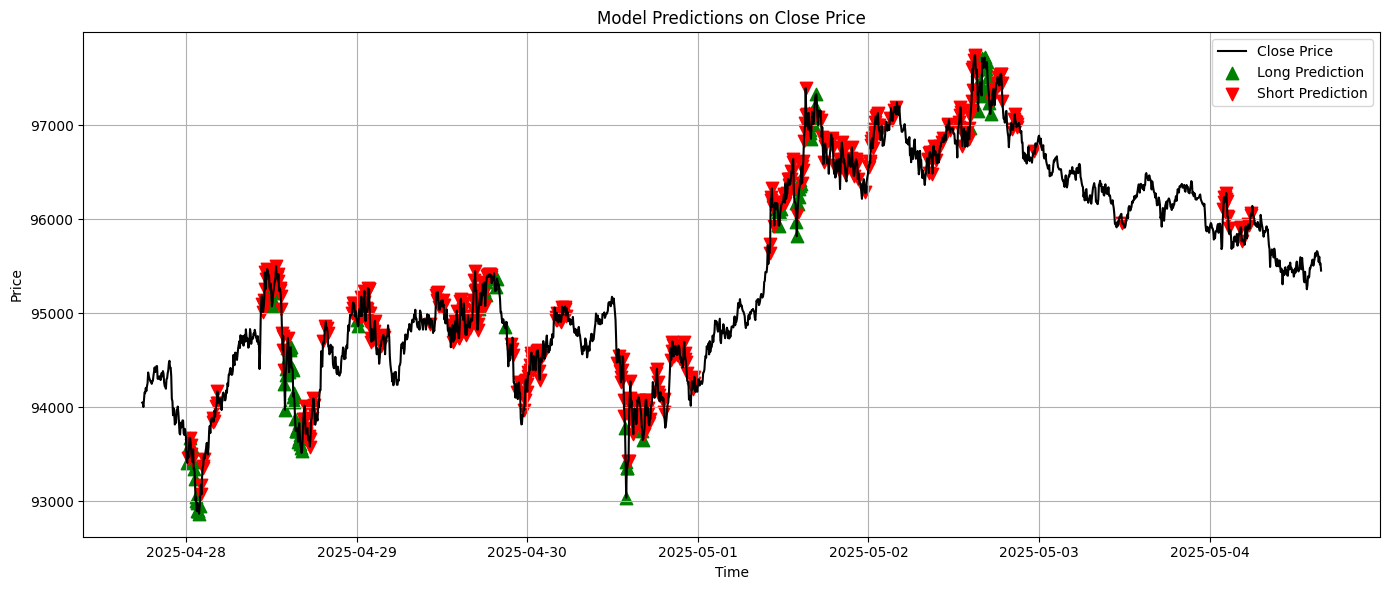

In [ ]:
# Make sure the test set has the corresponding timestamps
test_prices = df.iloc[split_idx:].copy()  # same split index as train/test
test_prices['pred'] = y_pred

# Map predicted class back to action label: 2 → 1 (long), 0 → -1 (short)
label_map_back = {0: -1, 1: 0, 2: 1}
test_prices['pred_signal'] = test_prices['pred'].map(label_map_back)

# Plot close price
plt.figure(figsize=(14, 6))
plt.plot(test_prices.index, test_prices['close'], label='Close Price', color='black')

# Plot long entries (pred_signal == 1)
plt.scatter(test_prices.index[test_prices['pred_signal'] == 1],
            test_prices['close'][test_prices['pred_signal'] == 1],
            label='Long Prediction', marker='^', color='green', s=80)

# Plot short entries (pred_signal == -1)
plt.scatter(test_prices.index[test_prices['pred_signal'] == -1],
            test_prices['close'][test_prices['pred_signal'] == -1],
            label='Short Prediction', marker='v', color='red', s=80)

plt.title("Model Predictions on Close Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()